In [1]:
from matplotlib import pyplot as plt
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Computer Modern Roman",
  "font.size":    14.0
})
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2


from geminids.read_data import *

In [2]:
fig_pth = "../figs"

## Load Data

In [3]:
# points = (np.load(f"../output/cached/points_0.npy"))

In [4]:

orbit = np.load("../data/orig_orbit.npy")
pth = "../output/" + "novel_8pl"
points = []
vels = []
mass = 0
n=100
for i in tqdm(range(n)):
    data = np.load(f'{pth}/particles{i}.npy')
    vel = np.load(f'{pth}/vels{i}.npy')
    beta = np.load(f'{pth}/beta{i}.npy')
    size = np.load(f'{pth}/mass{i}.npy')
    size = asteroidal(beta)
    data = data.reshape(10000*10*2, 5)
    data = data[:,:3]
    vels.append(vel)

    s = 5
    points.append(np.hstack((data, np.tile(size,2000).reshape(200000,1),
                            np.tile(weight_novel(beta),
                                    2000).reshape(200000,1))))
    mass += np.sum(size[(~np.isnan(size * weight_novel(beta)))]
                * weight_novel(beta[(~np.isnan(size * weight_novel(beta)))]))


mass *= 2000
vels=np.array(vels)
vels=vels.reshape(200000*n,3)
points = np.array(points)
points = points.reshape(200000*n,s)
points = points[~np.isnan(points).any(axis=1)]


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


In [5]:
vels.shape

(20000000, 3)

In [6]:

def _quadratic(x, a, b, c):
    return a*(x**2) + b * (x**1)  + c

def plot_residual_fit2(peri_fit, color="cyan"):
    (
        r,
        theta,
        orbit_r,
        orbit_theta,
        f,
        offsets,
        thetas,
        offset_mask,
        offset_rs,
        peri_novel) = peri_fit

    [a,b,c] , corr = curve_fit(_quadratic,
                               thetas/np.pi*180,
                               offsets*AU_TO_M/1000)

    
    #print(np.min((theta[offset_mask]/np.pi*180)[:-1] - (theta[offset_mask]/np.pi*180)[1:]))

    plt.hexbin(theta[offset_mask]/np.pi*180,
               offset_rs*AU_TO_M/1000/1e5,
               cmap="plasma",
               extent=(orbit_theta.min()/np.pi*180,
                       orbit_theta.max()/np.pi*180,
                       -.03*AU_TO_M/1000/1e5,
                       .02*AU_TO_M/1000/1e5),
               gridsize=1000)


    plt.scatter(thetas/np.pi*180,
                offsets*AU_TO_M/1000/1e5,
                c=color,
                s=7)

    plt.plot(thetas/np.pi*180,
             _quadratic(thetas/np.pi*180, a,b,c)/1e5,
             "k--",
             label = rf"y = {a:.2e}$x^2$ + {b:.2e}$x$ + {c:.2e}")

    plt.legend()
    plt.xlabel(r"Mean Anomonly ($^\circ$)")
    plt.ylabel(r"Radial Offset from 3200 Phaethon ($10^5$ km)")
    return corr


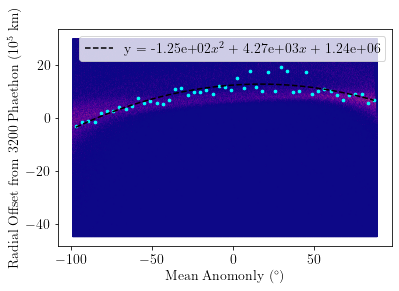

[[ 1.57973508e+02  1.60181274e+03 -4.61117157e+05]
 [ 1.60181274e+03  3.87918942e+05 -2.79125846e+06]
 [-4.61117157e+05 -2.79125846e+06  2.44999331e+09]]


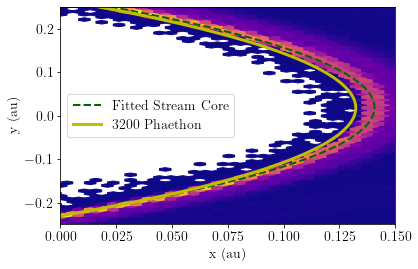

In [31]:
n = [100, 100, 1000]
orbit = get_phaethon_orbit()
psp = get_parker_orbit()
c = ["cyan", "cyan", "darkgreen"]

i =0 
p = points

peri_fit = fit_perihelion(p, orbit)

corr = plot_residual_fit2(peri_fit, color=c[i])
#plt.savefig(f"{fig_pth}/residual_{i}.eps")
plt.show()
print(corr)

plot_smoothed_fit(peri_fit)
# plt.savefig(f"{fig_pth}/smooth_fit_{i}.eps")
plt.show()

100%|██████████| 8000/8000 [02:52<00:00, 46.45it/s]  


IndexError: list index out of range

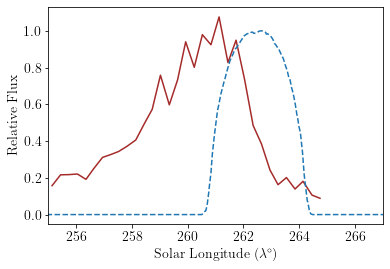

In [53]:

points_m5 = []
KDTrees = []
for i in range(1):
    point_m5, KDTree = generate_KDTree(points, 4.2e-4, 0.9, 1.1)
    points_m5.append(point_m5)
    KDTrees.append(KDTree)

rates, long, t, avg_vels, earth_vels = rate_at_earth(points_m5, KDTrees, r=0.03, vels=vels)
# calibrated_masses = [calibrated_mass(masses[i], rates[i]) * adjustment_factor(1e-5) for i in range(3)]

# print(f"The estimated mass for the BASE model is:\t\t{'{:.2e}'.format(calibrated_masses[0])}")
# print(f"The estimated mass for the VEL model is:\t\t{'{:.2e}'.format(calibrated_masses[1])}")
# print(f"The estimated mass for the DISTR model is:\t\t{'{:.2e}'.format(calibrated_masses[2])}")

peaks, fwhm, peak_vel = plot_at_earth(rates, 
                      long, 
                      labels=["Basic Model", "Violent Creation", "Cometary Creation"],
                      plot_cmor=True) 
plt.savefig(f"{fig_pth}/rates_at_earth.eps")
plt.show()

print(f"The peak longitude for the BASIC model is:\t{peaks[0]}\t with a full-width, half-max of\t{fwhm[0]}")
# print(f"The peak longitude for the VIOLENT model is:\t{peaks[1]}\t with a full-width, half-max of\t{fwhm[1]}")
# print(f"The peak longitude for the COMETARY model is:\t{peaks[2]}\t with a full-width, half-max of\t{fwhm[2]}")

In [91]:
v_inf = np.sqrt(np.sum((((avg_vels[np.argmax(rates)]+earth_vels[np.argmax(rates)]) * AU_TO_M)**2)))
v_inf

32528.09325860697

In [92]:
v_inf = np.sqrt(np.sum((((avg_vels[np.argmax(rates)]-earth_vels[np.argmax(rates)]) * AU_TO_M)**2)))
v_inf

28108.298512554047

In [90]:
from geminids.constants import *
np.sqrt(1 + (GRAVITATIONAL_CONSTANT * MASS_E)/(RADIUS_EARTH * (v_inf)**2)) * v_inf - v_inf

947.9246927947825

In [88]:
np.sqrt(np.sum(avg_vels[np.argmax(rates)]**2)) * AU_TO_M

2852.4666939254225

In [20]:
rates[0][4]

0.0

In [50]:
earth_vels*AU_TO_M

array([[-27045.42954478, -12462.30491417,  -5403.52035721],
       [-27028.10322275, -12493.92400489,  -5417.22008877],
       [-27002.02989471, -12541.31863246,  -5437.75440659],
       ...,
       [-27091.00546391, -12378.98633907,  -5367.04528208],
       [-27064.76196529, -12426.24160466,  -5387.55686466],
       [-27038.42554113, -12473.44527222,  -5408.04560925]])

In [153]:
rel_vel = vels[np.argmax(rates)]+earth_vels[np.argmax(rates)]
# rel_vel[1], rel_vel[2] = rel_vel[2], rel_vel[1]

In [88]:

np.arctan2(rel_vel[1], np.sqrt(rel_vel[0]**2 + rel_vel[2]**2))/np.pi * 180

4.22442924993967

In [79]:
import spiceypy as spice
np.sqrt(np.sum(((vels[0][np.argmax(rates)] - earth_vels[np.argmax(rates)])*AU_TO_M)**2))

IndexError: index 3631 is out of bounds for axis 0 with size 3

In [179]:
peak_vel[2]

-6.3218921214487724e-09

In [223]:
peak_vel = avg_vels[np.argmax(rates)]

np.arctan2(peak_vel[2], 
          np.sqrt(peak_vel[0]**2 + peak_vel[1]**2))/np.pi*180

np.arctan2(peak_vel[0], peak_vel[1])/np.pi*180 


-116.10144387660266

In [16]:
vels

array([[ 7.79676283e-08,  1.15634208e-07,  2.76283000e-08],
       [-4.77505284e-08,  4.75023964e-09, -2.01636818e-08],
       [-8.70913222e-08, -6.23928012e-08, -3.36585005e-08],
       ...,
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan]])

In [72]:
rel_vel

array([-2.21687566e-07,  6.30842375e-08, -1.02086020e-08])

In [78]:
radec = np.array(spice.recrad(-1*avg_vels[np.argmax(rates)]))/np.pi * 180
radec

array([1.09249084e-06, 3.11808496e+01, 7.99492394e+00])

In [218]:
spice.recrad([0.0000,-1,1])

(1.4142135623730951, 4.71238898038469, 0.7853981633974483)

In [217]:
np.arctan2(1,0)

1.5707963267948966

In [165]:
avg_vels[rates[0]>0]*AU_TO_M

array([[-7758.60829781, -9208.96360694, -2833.06085147],
       [-6936.4262328 , -6525.81808091, -2598.64579239],
       [-2378.36988211, -1962.41369873,  -894.39419473],
       [-3355.89827736, -3133.06632068, -1252.9320144 ],
       [-2958.57522619, -2262.35925421, -1124.3316441 ],
       [-2911.84554874, -1722.74302432, -1128.04253384],
       [-2943.41008206, -1818.76897274, -1137.83151989],
       [-2966.49276064, -1937.32642622, -1142.66690341],
       [-2773.08605363, -1923.14281487, -1062.98620768],
       [-2742.2039837 , -2089.59382557, -1043.11493251],
       [-2732.40613022, -1927.4352892 , -1045.92279009],
       [-2442.06028937, -1783.54488391,  -931.63433382],
       [-2361.46911647, -1664.00156791,  -903.33111881],
       [-2440.3752966 , -1722.89174168,  -933.63600871],
       [-2544.99951603, -1868.96471458,  -971.00275789],
       [-2599.44631466, -1863.68466052,  -993.72263331],
       [-2585.2172232 , -1770.43946294,  -991.6154995 ],
       [-2467.29116743, -1669.5

In [14]:
earth_vels*AU_TO_M

array([[-27045.42954478, -12462.30491417,  -5403.52035721],
       [-27028.10322275, -12493.92400489,  -5417.22008877],
       [-27002.02989471, -12541.31863246,  -5437.75440659],
       ...,
       [-27091.00546391, -12378.98633907,  -5367.04528208],
       [-27064.76196529, -12426.24160466,  -5387.55686466],
       [-27038.42554113, -12473.44527222,  -5408.04560925]])

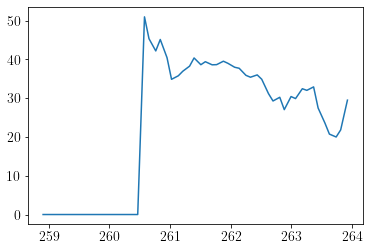

In [102]:
avg_vels

recrad = np.array([(spice.recrad((-avg_vels[i])*AU_TO_M)) 
                   for i in range(rates.shape[1])])/np.pi * 180

long2 = long/np.pi * 180 + 180
plt.plot(long2[np.argmax(rates)-40:np.argmax(rates)+15], recrad[np.argmax(rates)-40:np.argmax(rates)+15,1])

In [37]:
rel_vel

array([ 1.79850100e-07,  1.33058407e-08, -1.02068837e-08])

In [61]:
np.sqrt(np.sum((avg_vels-earth_vels)**2,axis=1)).shape

(8000,)

In [62]:
long.shape

(8000,)

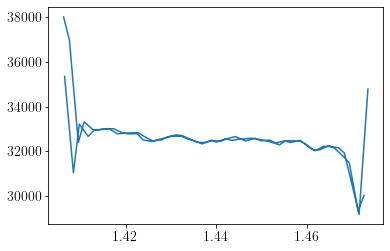

In [148]:
plt.plot(long, np.sqrt(np.sum((avg_vels+earth_vels)**2,axis=1))*AU_TO_M)
plt.plot([long[np.argmax(rates)]]*2, [30255, 30270], "r--")

In [52]:
m = np.mean(rates[0,np.argmax(rates)-10:np.argmax(rates)+10] * np.sqrt(np.sum((avg_vels + earth_vels)**2, axis=1))[np.argmax(rates)-10:np.argmax(rates)+10])/np.sum(rates[0,np.argmax(rates)-20:np.argmax(rates)+20])
m*AU_TO_M

982.7178654064309

In [16]:
et = spice.str2et('2020-01-01')
eclip2eq = spice.sxform("ECLIPJ2000", "J2000", et)

In [18]:
avg_vels

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [21]:
eclip2eq[:3, :3]

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.91748206, -0.39777716],
       [ 0.        ,  0.39777716,  0.91748206]])

In [23]:
eclip2eq[3:, 3:]

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.91748206, -0.39777716],
       [ 0.        ,  0.39777716,  0.91748206]])

In [82]:
avg_vels[rates[0]>0].shape

(84, 3)

In [120]:
recrad[rates[0]>0]

array([[ 2.79774759e+06,  1.96652483e+02, -7.13206638e+00],
       [ 2.76840885e+06,  1.95710855e+02, -7.11486815e+00],
       [ 2.73634813e+06,  1.94686700e+02, -7.08188829e+00],
       [ 2.85454400e+06,  1.98551816e+02, -7.09502204e+00],
       [ 2.99554154e+06,  2.02886016e+02, -6.97307659e+00],
       [ 2.85084595e+06,  1.98419392e+02, -7.08906064e+00],
       [ 2.80644914e+06,  1.97098839e+02, -7.07059304e+00],
       [ 2.76918141e+06,  1.96079204e+02, -7.05490096e+00],
       [ 2.63040249e+06,  1.91480853e+02, -6.93074247e+00],
       [ 2.28070864e+06,  1.78096532e+02, -5.57443922e+00],
       [ 2.27559813e+06,  1.77902096e+02, -5.53247165e+00],
       [ 5.17980382e+06,  2.75938185e+02,  1.27724180e+01],
       [ 2.01772849e+06,  1.65479096e+02, -3.06230701e+00],
       [ 1.69841524e+06,  1.40943176e+02,  4.48813013e+00],
       [ 2.09874963e+06,  1.69995388e+02, -4.04020277e+00],
       [ 1.74306111e+06,  1.46064243e+02,  2.73741625e+00],
       [ 4.28337234e+06,  3.34315494e+02

In [119]:
m = np.sum(rates[0,rates[0]>0]*recrad[rates[0]>0,1])/ np.sum(rates[0,rates[0]>0])

std = np.std(rates[0,rates[0]>0]*recrad[rates[0]>0,1])/ np.sum(rates[0,rates[0]>0])*180/np.pi

print(f"{m} +/- {std}")

168.3714286629708 +/- 57.661681003715074


In [105]:
avg_vels.shape

(8000, 3)

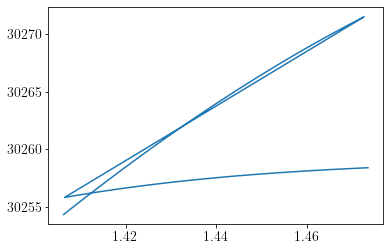

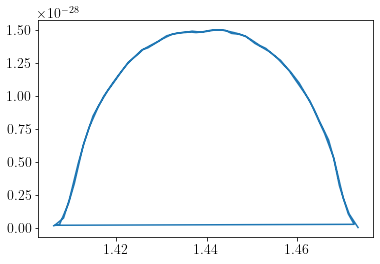

In [144]:
plt.plot(long[rates[0]>0], np.sqrt(np.sum((earth_vels)**2, axis=1))[rates[0]>0] * AU_TO_M)
plt.show()
plt.plot(long[rates[0]>0], rates[0, rates[0]>0])

In [142]:
avg_vels[rates[0]>0]

array([[-7.32151465e-14, -8.69016186e-14, -2.67345582e-14],
       [-6.53008325e-14, -6.14352894e-14, -2.44641445e-14],
       [-3.16469189e-14, -2.61121484e-14, -1.19009330e-14],
       [-4.93916825e-14, -4.61120702e-14, -1.84404935e-14],
       [-4.68756796e-14, -3.58448305e-14, -1.78139158e-14],
       [-4.63819794e-14, -2.74410954e-14, -1.79682764e-14],
       [-4.71515688e-14, -2.91355292e-14, -1.82273416e-14],
       [-4.74501029e-14, -3.09882227e-14, -1.82773620e-14],
       [-4.44810528e-14, -3.08477326e-14, -1.70505872e-14],
       [-4.43755641e-14, -3.38147364e-14, -1.68801496e-14],
       [-4.43622653e-14, -3.12930771e-14, -1.69811888e-14],
       [-3.96661562e-14, -2.89699522e-14, -1.51324491e-14],
       [-3.83833540e-14, -2.70467061e-14, -1.46827574e-14],
       [-3.96486340e-14, -2.79917209e-14, -1.51687294e-14],
       [-4.14273440e-14, -3.04228915e-14, -1.58059226e-14],
       [-4.21944349e-14, -3.02514888e-14, -1.61301908e-14],
       [-4.21240545e-14, -2.88479002e-14

In [103]:
weights = rates[0, rates[0]>0]/np.sum(rates[0, rates[0]>0])

m = np.sum(weights*(np.sqrt(np.sum((avg_vels)**2, axis=1)))[rates[0]>0])*AU_TO_M

std = np.sqrt(np.sum(weights*(np.sqrt(np.sum((avg_vels)**2, axis=1))[rates[0]>0]*AU_TO_M  -m)**2))

print(f"{m} +/- {std}")

2944.823381087723 +/- 499.4182881799482


In [104]:
weights = rates[0, rates[0]>0]/np.sum(rates[0, rates[0]>0])

m = np.sum(weights*(recrad[rates[0]>0,2]))

std = np.sqrt(np.sum(weights*(recrad[rates[0]>0,2]  -m)**2))

print(f"{m} +/- {std}")

6.219125558877895 +/- 4.070652751153225


In [105]:
weights = rates[0, rates[0]>0]/np.sum(rates[0, rates[0]>0])

m = np.sum(weights*(recrad[rates[0]>0,1]))

std = np.sqrt(np.sum(weights*(recrad[rates[0]>0,1]  -m)**2))

print(f"{m} +/- {std}")

34.319871860476276 +/- 11.62310650186292


In [ ]:
347, 29

In [123]:
spice.jyear()

31557600.0

In [141]:
180 - radec[2]

165.27024947497983

In [142]:
radec

array([5.90129949e-05, 3.23832938e+02, 1.47297505e+01])

In [143]:
180-32

148